# use python api

In [1]:
import os
# os.chdir()
os.getcwd()

'/mnt/data/ai4phys/louzekun/projects/mmlab/mmpose'

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## prepare
- load image, detect model, pose model

img_size=(2520, 1418)


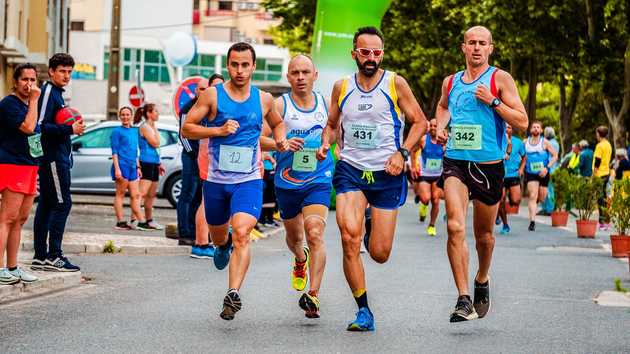

In [11]:
# load image
img_path = 'data/test/multi-person.jpeg'
img = Image.open(img_path)
img_size = img.size
print(f"{img_size=}")
img_size_resize = tuple([i//4 for i in img_size])
img_resized = img.resize(img_size_resize, Image.LANCZOS)
img_resized

In [12]:
# load detection model
# Faster R CNN
detector = init_detector(
    'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [ ]:
# load detection model, optional, just need one
# # RTMPose-Tiny
# # https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
# detector = init_detector(
#     'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
#     'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
#     device=device
# )

In [13]:
# load pose model
pose_estimator = init_pose_estimator(
    'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## detect

In [14]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

06/03 17:44:27 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [15]:
# detect the img
detect_result = inference_detector(detector, img_path)
detect_result.keys()


['gt_instances', 'ignored_instances', 'pred_instances']

In [23]:
# prediction categories
print(detect_result.pred_instances.labels)
# confidence scores
print(detect_result.pred_instances.scores)
# bounding boxes
# detect_result.pred_instances.bboxes.shape


tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0, 58,  0,  0, 58,  0,  0,  2,
         0,  0,  2,  0,  0,  0,  0, 24,  2, 58, 26, 26,  0,  0, 58,  0, 26,  0,
        27, 24,  0, 26, 26, 26, 26, 26, 58,  0, 26, 26, 26,  2, 32,  2, 58, 39,
         2,  0, 58, 24, 58, 32, 24, 26,  0,  0,  2, 37,  0, 39,  9, 74,  0,  2,
        58, 24,  0,  0, 26, 29], device='cuda:0')
tensor([0.9994, 0.9988, 0.9974, 0.9963, 0.9959, 0.9930, 0.9914, 0.9901, 0.9868,
        0.9824, 0.9632, 0.9272, 0.9080, 0.8950, 0.8794, 0.8582, 0.8248, 0.8189,
        0.7240, 0.7186, 0.7054, 0.6653, 0.6203, 0.6011, 0.6002, 0.5708, 0.5653,
        0.5058, 0.4551, 0.4088, 0.3942, 0.3910, 0.3534, 0.3103, 0.3030, 0.2595,
        0.2293, 0.2222, 0.2156, 0.1888, 0.1866, 0.1847, 0.1791, 0.1771, 0.1716,
        0.1674, 0.1398, 0.1391, 0.1390, 0.1372, 0.1348, 0.1250, 0.1205, 0.1156,
        0.1132, 0.1120, 0.1010, 0.1009, 0.0939, 0.0921, 0.0919, 0.0914, 0.0885,
        0.0822, 0.0806, 0.0724, 0.0697, 0.0686, 0.0675, 0.0630, 0.0626

In [45]:
# filter by confidence
CONF_THRESH = 0.5
pred_instances = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate([pred_instances.bboxes, pred_instances.scores[:, None]], axis=1)
bboxes_select = np.logical_and(pred_instances.labels == 0, pred_instances.scores > CONF_THRESH)
bboxes = bboxes[bboxes_select]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]  # nms input format is [x1, y1, x2, y2, score], so must concatenate
bboxes

array([[1705.6395  ,   96.27866 , 2114.5183  , 1301.1775  ],
       [1267.6166  ,   94.72074 , 1701.0613  , 1316.285   ],
       [ 720.3953  ,  172.2457  , 1152.6997  , 1267.8168  ],
       [   7.261622,  238.25699 ,  171.00162 , 1140.7931  ],
       [1063.189   ,  219.21948 , 1348.983   , 1244.7246  ],
       [ 436.23563 ,  428.57886 ,  586.08997 ,  911.8915  ],
       [ 110.011604,  212.1345  ,  324.64398 , 1123.0076  ],
       [2079.3335  ,  478.24326 , 2224.4055  ,  925.21063 ],
       [ 543.71063 ,  406.47455 ,  650.83386 ,  919.4688  ],
       [2363.3005  ,  501.8654  , 2455.2263  ,  857.30334 ],
       [2308.1978  ,  561.45245 , 2372.7483  ,  715.7735  ],
       [1990.6123  ,  485.11066 , 2105.634   ,  923.436   ],
       [2255.5364  ,  568.4511  , 2326.8687  ,  702.4379  ],
       [ 830.38745 ,  297.20972 ,  897.03955 ,  349.5923  ],
       [ 704.99396 ,  419.5892  ,  808.6931  ,  989.6114  ],
       [1646.6827  ,  484.4085  , 1787.3207  ,  936.50195 ],
       [2437.2595  ,  59

In [49]:
# predict poses of bboxes
pose_results = inference_topdown(pose_estimator, img_path, bboxes)
len(pose_results)

18

In [57]:
# merge pose
data_samples = merge_data_samples(pose_results)
data_samples.keys(), data_samples.pred_instances.keypoints.shape  # 17 points for one person, 18 persons in total

(['pred_fields', 'gt_instances', '_pred_heatmaps', 'pred_instances'],
 (18, 17, 2))

(17, 1418, 2520)


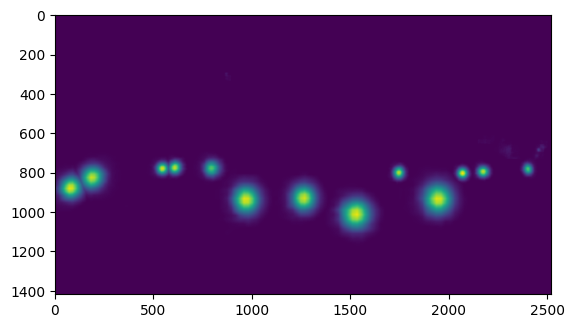

In [61]:
# prediction heatmap for each kind of keypoints (17 keypoints in total)
print(data_samples.pred_fields.heatmaps.shape)  # the last two dimensions are img height and width
plt.imshow(data_samples.pred_fields.heatmaps[13,:])  # the 13th keypoints' heatmap
plt.show()

## Visualizer
use MMPose built-in visualizer


In [66]:
# instantialize visualizer
pose_estimator.cfg.visualizer.radius = 10  # radius
pose_estimator.cfg.visualizer.line_width = 8  # line with
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
visualizer.set_dataset_meta(pose_estimator.dataset_meta)
pose_estimator.dataset_meta  # show meta data

/home/louzekun/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


{'dataset_name': 'coco',
 'num_keypoints': 17,
 'keypoint_id2name': {0: 'nose',
  1: 'left_eye',
  2: 'right_eye',
  3: 'left_ear',
  4: 'right_ear',
  5: 'left_shoulder',
  6: 'right_shoulder',
  7: 'left_elbow',
  8: 'right_elbow',
  9: 'left_wrist',
  10: 'right_wrist',
  11: 'left_hip',
  12: 'right_hip',
  13: 'left_knee',
  14: 'right_knee',
  15: 'left_ankle',
  16: 'right_ankle'},
 'keypoint_name2id': {'nose': 0,
  'left_eye': 1,
  'right_eye': 2,
  'left_ear': 3,
  'right_ear': 4,
  'left_shoulder': 5,
  'right_shoulder': 6,
  'left_elbow': 7,
  'right_elbow': 8,
  'left_wrist': 9,
  'right_wrist': 10,
  'left_hip': 11,
  'right_hip': 12,
  'left_knee': 13,
  'right_knee': 14,
  'left_ankle': 15,
  'right_ankle': 16},
 'upper_body_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'lower_body_ids': [11, 12, 13, 14, 15, 16],
 'flip_indices': [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15],
 'flip_pairs': [(2, 1),
  (1, 2),
  (4, 3),
  (3, 4),
  (6, 5),
  (5, 6),
  (8, 7),
  

In [69]:
# visualize
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')
img_output = visualizer.add_datasample(
    'result',
    img,
    data_sample=data_samples,
    draw_gt=True,
    draw_heatmap=True,
    draw_bbox=True,
    show_kpt_idx=False,
    show=False,
    wait_time=0,
    out_file='outputs/B2.jpg'
)
img_output.shape

(2836, 5040, 3)

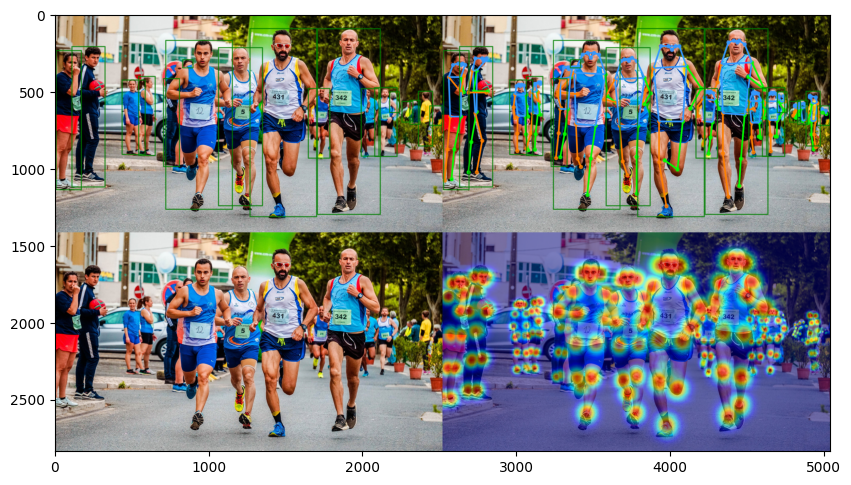

In [70]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()